## Uso de 2 GPUs, usando locks: TEXTO

In [1]:
# Seleccionamos la GPU que vamos a usar, y vamos cambiandola según haga falta
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

### Paquetes

In [1]:
%pip install -Uq diffusers ftfy accelerate

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -U bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 110.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: bitsandbytes
    Found existing installation: bitsandbytes 0.42.0
    Uninstalling bitsandbytes-0.42.0:
      Successfully uninstalled bitsandbytes-0.42.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --pre torchvision -f https://download.pytorch.org/whl/nightly/cu124/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu124/torch_nightly.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 74.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 116.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 116.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 97.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 117.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 117.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 121.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
%pip install sentencepiece tokenizers

Note: you may need to restart the kernel to use updated packages.


In [5]:
#########################
%pip install transformers==4.48.0
#########################
# %pip install diffusers torch transformers ipywidgets accelerate protobuf sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 63.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 76.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Uninstalling transformers-4.36.2:
      Successfully uninstalled transformers-4.36.2
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install backports.weakref

Note: you may need to restart the kernel to use updated packages.


### Cargar modelos

In [7]:
import torch

num_gpus = torch.cuda.device_count()
print(num_gpus)

device = torch.device("cuda")

1


In [9]:
%pip list | grep transformers

transformers                  4.48.0
Note: you may need to restart the kernel to use updated packages.


#### Phi-3.5-vision-instruct

In [3]:
from PIL import Image 
from transformers import AutoModelForCausalLM 
from transformers import AutoProcessor 

model_id = "microsoft/Phi-3.5-vision-instruct" 

# Note: set _attn_implementation='eager' if you don't have flash_attn installed
model = AutoModelForCausalLM.from_pretrained(
  model_id, 
  device_map="cuda", 
  trust_remote_code=True, 
  torch_dtype="auto", 
  _attn_implementation='eager'    
)

# for best performance, use num_crops=4 for multi-frame, num_crops=16 for single-frame.
processor = AutoProcessor.from_pretrained(model_id, 
  trust_remote_code=True, 
  num_crops=16  # Changed to 16 for single-frame
) 

2025-04-03 17:31:06.123921: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


ModuleNotFoundError: No module named 'transformers_modules.microsoft.Phi-3'

In [11]:
# Baja Temperatura (0.2–0.5):
# Generaciones más deterministas. Descripción precisa y repetible 

# Moderada Temperatura (0.7–1.0):
# Introduce cierta creatividad en las respuestas. Contenido creativo o literatura.

# Alta Temperatura (>1.0):
# Aumenta la diversidad y creatividad, pero puede generar resultados incoherentes. Exploración.

TEMPERATURE = 0.7

In [12]:
def describe_image(image_path):
    placeholder = ""
    it_img = image_path

    placeholder += "<|image_1|>\n"
    messages = [
        {"role": "user", "content":  placeholder + "Describe image_1, in 300 words"},
    ]
    
    # Preparar el prompt para la entrada del modelo
    prompt = processor.tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
    )
    
    # Procesar la entrada y enviarla al dispositivo correspondiente
    inputs = processor(prompt,
                       it_img,
                       return_tensors="pt").to(device) 
    
    # Definir argumentos de generación
    generation_args = { 
        "max_new_tokens": 1000,
        # "min_new_tokens":400,
        "temperature": TEMPERATURE, 
        "do_sample": True,
        "top_k": 50
    } 
    
    # Generar la respuesta
    generate_ids = model.generate(
        **inputs, 
        eos_token_id=32000, 
        **generation_args
    )
    # print(generate_ids.shape, generate_ids[:, inputs['input_ids'].shape[1]:].shape, inputs['input_ids'].shape)
    
    # Obtener sólo los tokens generados a partir de los IDs de entrada
    generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
    response = processor.batch_decode(
        generate_ids, 
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=True
    )[0] 
    return response

In [24]:
ruta_img = "./imagenes paper original/dataset_coco_imgs/fire hydrant/"
name_img= "555472.jpg"

### Generar descripciones manualmente

In [17]:
img_path = f"{ruta_img}{name_img}"
# print(img_path)

img = Image.open(img_path)
text = describe_image(img)
words =  text.split()
print(text, len(words))

In the midst of a lush savanna, an elephant, the embodiment of strength and majesty, strides confidently across the asphalt road. The elephant's skin is a rich, dark brown canvas, hinting at the wisdom and age it embodies. Its large, curved ears are a testament to its towering height, and its tusks gleam in the sunlight, sharp and ready.

The elephant is not alone. In the background, a vehicle - a symbol of human presence and progress - is parked on the side of the road. It stands as a silent observer to this moment of tranquility, its beige color blending seamlessly with the savanna landscape.

The scene is a harmonious blend of nature and humanity. The elephant, a creature of the wild, is sharing the road with a symbol of human advancement. It's a moment frozen in time, a snapshot of the coexistence of two worlds - the natural and the man-made.

Every detail in this image tells a story - from the elephant's journey across the road to the vehicle parked in the background, each element

In [22]:
from PIL import Image
from tqdm import tqdm  # Importar tqdm para la barra de progreso

img = Image.open(img_path)

suma = 0
num_its = 20
# Usar tqdm para mostrar una barra de progreso en el bucle
for i in tqdm(range(num_its), desc="Procesando iteraciones"):
    it_txt = describe_image(img)
    # Texto a tokenizar
    text = it_txt
    words =  text.split()       
    print(it_txt)
    word_count = len(words)
    print("Número de palabras:", word_count)

    suma += word_count
    

media = suma / num_its

print("Media de palabras:", media)


Procesando iteraciones:   5%|▌         | 1/20 [00:07<02:13,  7.05s/it]

In the heart of a sunlit room, a young girl, clad in a vibrant red shirt, finds joy in the company of her pet dog. The dog, a charming white terrier with a touch of gray on its ears, sits comfortably on the girl's lap. The girl, holding a tennis racket in her left hand, looks directly into the camera, her face lit up with a bright smile. The dog, however, seems more interested in a tennis ball held in the girl's right hand than in the camera's lens. The image captures a moment of pure, unadulterated happiness between a girl and her dog, set against the backdrop of a simple wooden chair and a bicycle leaning against a wall.
Número de palabras: 120


Procesando iteraciones:  10%|█         | 2/20 [00:10<01:25,  4.74s/it]

In the image, a young girl is sitting on a chair outside, with a small dog on her lap. She is wearing a red shirt and is holding a tennis racket in her left hand, while the dog is holding a tennis ball in its mouth. A bicycle can be seen leaning against a nearby wall.
Número de palabras: 56


Procesando iteraciones:  15%|█▌        | 3/20 [00:14<01:14,  4.41s/it]

A young girl is sitting on a lawn chair outside, holding a small dog in her lap. The dog appears to be a white terrier, and the girl is wearing a red shirt. She is holding a tennis racket in one hand and a tennis ball in the other. In the background, there is a bicycle leaning against a wall. The scene appears to be taking place on a patio or backyard.
Número de palabras: 72


Procesando iteraciones:  20%|██        | 4/20 [00:19<01:17,  4.82s/it]

In the image, a young girl is sitting on a chair with a small dog on her lap. The girl is wearing a red top and is holding a tennis racket in her right hand. The dog is a small, white, and grey breed, and is wearing a purple collar. They are sitting in front of a wooden wall, with a bicycle and a ladder leaning against it. The floor is made of concrete, and there is a red chair and a table nearby. The girl is smiling at the camera, and the dog appears to be calm and relaxed.
Número de palabras: 100


Procesando iteraciones:  25%|██▌       | 5/20 [00:27<01:31,  6.07s/it]

In the heart of a sunlit patio, a young girl finds joy in a simple moment, her face lit with a smile as wide as the blue and yellow tennis racket she holds. Her companion, a white dog with a purple collar, sits obediently in her lap, its head resting gently on a green tennis ball. The dog's eyes, full of trust and happiness, reflect the innocence of youth. The girl, dressed in a vibrant red top and white shorts, seems to be in her own world, her attention focused on the dog. Behind them, a wooden fence stands as a silent observer to their delight. The fence, adorned with a sign that reads 'SALE', adds a touch of realism to the scene. The image captures a moment of pure, unadulterated joy, a testament to the simple pleasures of life.
Número de palabras: 140


Procesando iteraciones:  30%|███       | 6/20 [00:32<01:19,  5.65s/it]

In the image, a young girl is sitting on a chair outside, holding a tennis ball in her right hand and a tennis racket in her left hand. She is smiling and seems to be enjoying her time with her dog, which is sitting on her lap. The dog is also smiling and appears to be happy as well. The background of the image shows a wooden fence, a window, and a bicycle. The girl is wearing a red shirt and the dog is wearing a purple collar.
Número de palabras: 88


Procesando iteraciones:  35%|███▌      | 7/20 [00:37<01:09,  5.38s/it]

A young girl is sitting on a chair with a small dog in her lap. The girl is holding a tennis racket in her left hand and a tennis ball in her right hand. The dog has a purple collar and is looking up at the girl with a smile. The girl is wearing a red shirt and shorts, and the dog is a small, fluffy, white and gray breed. In the background, there is a bicycle leaning against the wall and a window with blinds.
Número de palabras: 86


Procesando iteraciones:  40%|████      | 8/20 [00:41<00:57,  4.76s/it]

A young girl is sitting on a chair with a white dog on her lap. She's wearing a red top and holding a tennis ball in her hand. The dog is wearing a purple collar. The girl is also holding a tennis racket. They are sitting in front of a wooden wall with a bicycle parked on the right side.
Número de palabras: 60


Procesando iteraciones:  40%|████      | 8/20 [00:43<01:05,  5.49s/it]


KeyboardInterrupt: 

### Prebucle

In [17]:
def check_length_description(desc, img): 
    # Funcion para regenerar la descripcion si es muy corta
    # Devuleve la primera descripción que sea lo suficientemente larga (o la mas larga de las 5 en su defecto) y su longitud
    i = 0
    words =  desc.split()
    initial_word_count = len(words)

    # Si la descripcion inicial es menor que el límite permitido, lo guardamos como inicial
    # Si es mayor, guardamos el tamaño para que nos permita hacer la comparación luego dentro del bucle
    if initial_word_count < MAX_LENGTH_DESC:
        final_desc = desc
        final_length = initial_word_count
    else:
        final_length = 0

    # HAcemos 10 iteraciones para intentar generar una descripción del tamaño requerido
    while i < 10:   
        
        # Contar el número de palabras
        words =  desc.split()
        word_count = len(words)
        print(f"Descripción {i} mide {word_count}")
        
        # Si la descripción es mayor que el límite, generar una descripcion nueva y pasar a la siguiente iteracion
        if word_count > MAX_LENGTH_DESC:    
            ("Prompt demsiado largo")
            desc = describe_image(img)
            i += 1

        # Si la descripción está dentro del límite superior, pero no del inferior, generar nueva descripción
        elif word_count <= MIN_LENGTH_DESC:
            
            # Si la longitud nueva es mayor que la última guardada, actualizar par mostrar las mas larga
            if final_length < word_count:
                print(f"Guardando {word_count} como tamaño temporal")
                final_desc = desc
                final_length = word_count
                
            desc = describe_image(img)
            i += 1

        # Si esta dentro de todos los límites, guardar la descripción y los límites y salir del bucle
        else:
            final_desc = desc
            final_length = word_count
            break

        
            
        
        

    return final_desc, final_length
    

In [25]:
id_img = ['25348','131714','574922','79924','581731','16805']

In [26]:
import os
directorios = []
rutas_condiciones = []
rutas_descripciones = []


for i in id_img: 
    directorio = f"{ruta_img}{i}/promt_1_sentence/"
    ruta_condiciones = f"{directorio}condiciones/"
    ruta_descripciones = f"{directorio}descripciones/"
    # Crear el directorio si no existe
    os.makedirs(directorio, exist_ok=True)
    # Crear el directorio si no existe
    os.makedirs(ruta_condiciones, exist_ok=True)
    # Crear el directorio si no existe
    os.makedirs(ruta_descripciones, exist_ok=True)
    directorios.append(directorio)
    rutas_condiciones.append(ruta_condiciones)
    rutas_descripciones.append(ruta_descripciones)

### Bucle

In [ ]:
import socket
import time
import io

NUM_ITERATIONS = 16
MIN_LENGTH_DESC = 150
MAX_LENGTH_DESC = 270

for num,id in enumerate(id_img):
    img_path = f"{ruta_img}{id}.jpg"
    print(f"\n\n\n-------------------------------------------{id}-------------------------------------------\n\n\n")

    img = Image.open(img_path)
    text = describe_image(img)
    words =  text.split()
    print(text, len(words))
    # Descripción inicial
    initial_description = text

    # Guardamos los parámetros de la generación de texto
    file_name = f'{rutas_condiciones[num]}param_texto.txt'    
    with open(file_name, "w") as file:
        file.write(f"Temperature: {TEMPERATURE}\nIterations: {NUM_ITERATIONS}")

    # Guardamos la descripción inicial
    file_name = f'{directorios[num]}/initial_largas_2.txt'    
    with open(file_name, "w") as file:
        file.write(initial_description)

    # Configuración del cliente
    client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client.connect(('localhost', 65432))  # Dirección y puerto del servidor

    all_word_count = []

    client.sendall(initial_description.encode())  # Enviar la descripción inicial

    # Loop para recibir imagen, generar nueva descripción y enviar de vuelta
    for i in range(NUM_ITERATIONS): 
        try:
            print(f"\nIteración {i+1}:")

            # Recibir el tamaño de la imagen primero
            img_size_data = client.recv(4)
            img_size = int.from_bytes(img_size_data, byteorder='big')

            # Recibir los datos binarios de la imagen
            img_data = b""
            while len(img_data) < img_size:
                img_data += client.recv(img_size - len(img_data))

            # Convertir los datos binarios en una imagen
            img = Image.open(io.BytesIO(img_data))

            # Generar una nueva descripción (esto puede ser más complejo dependiendo del modelo)
            generated_description = describe_image(img)
            generated_description, word_count = check_length_description(generated_description, img)
            print(f"Generando nueva descripción: {generated_description}\n Tamaño: {word_count}")
            all_word_count.append(word_count)

            if i<=9:# Nombre del archivo
                file_name = f'{rutas_descripciones[num]}/generated_descr{0}{0}{i}.txt'    
                # Abrir el archivo en modo escritura y guardar el string
                with open(file_name, "w") as file:
                    file.write(generated_description)
            else:
                file_name = f'{rutas_descripciones[num]}/generated_descr{0}{i}.txt'    
                # Abrir el archivo en modo escritura y guardar el string
                with open(file_name, "w") as file:
                    file.write(generated_description)

            # Enviar la nueva descripción a Notebook 1
            client.sendall(generated_description.encode())

            if i == NUM_ITERATIONS-1:
                encodedEnd = bytes("END", 'utf-8')
                client.sendall(encodedEnd)
                time.sleep(10)

            time.sleep(1)  # Simular tiempo de procesamiento
        except KeyboardInterrupt:
            print("Closing client manually")
            break

    client.close()
    time.sleep(100)


-------------------------------------------25348-------------------------------------------
The image captures a scene of a weathered red fire hydrant standing alone in a grassy field. The hydrant, showing signs of age and exposure to the elements, is adorned with patches of rust and peeling paint, revealing the metal beneath in places. A blue sticker, a sign of human interaction, is affixed to the top of the hydrant, adding a splash of color to the otherwise faded red. The hydrant is situated in front of a picnic table, suggesting the presence of a recreational area nearby. The perspective of the image is from the side, offering a view that showcases the hydrant's robust design and resilience despite its worn-out appearance. The lush green grass underfoot contrasts with the red of the hydrant, creating a striking visual contrast. The background is filled with trees, hinting at the seclusion of the hydrant in this natural setting. The overall scene paints a picture of a quiet, possibly

In [ ]:
import matplotlib.pyplot as plt
    
plt.plot(all_word_count)
plt.show()

In [28]:
client.close()


### Plot all images in the same subplot

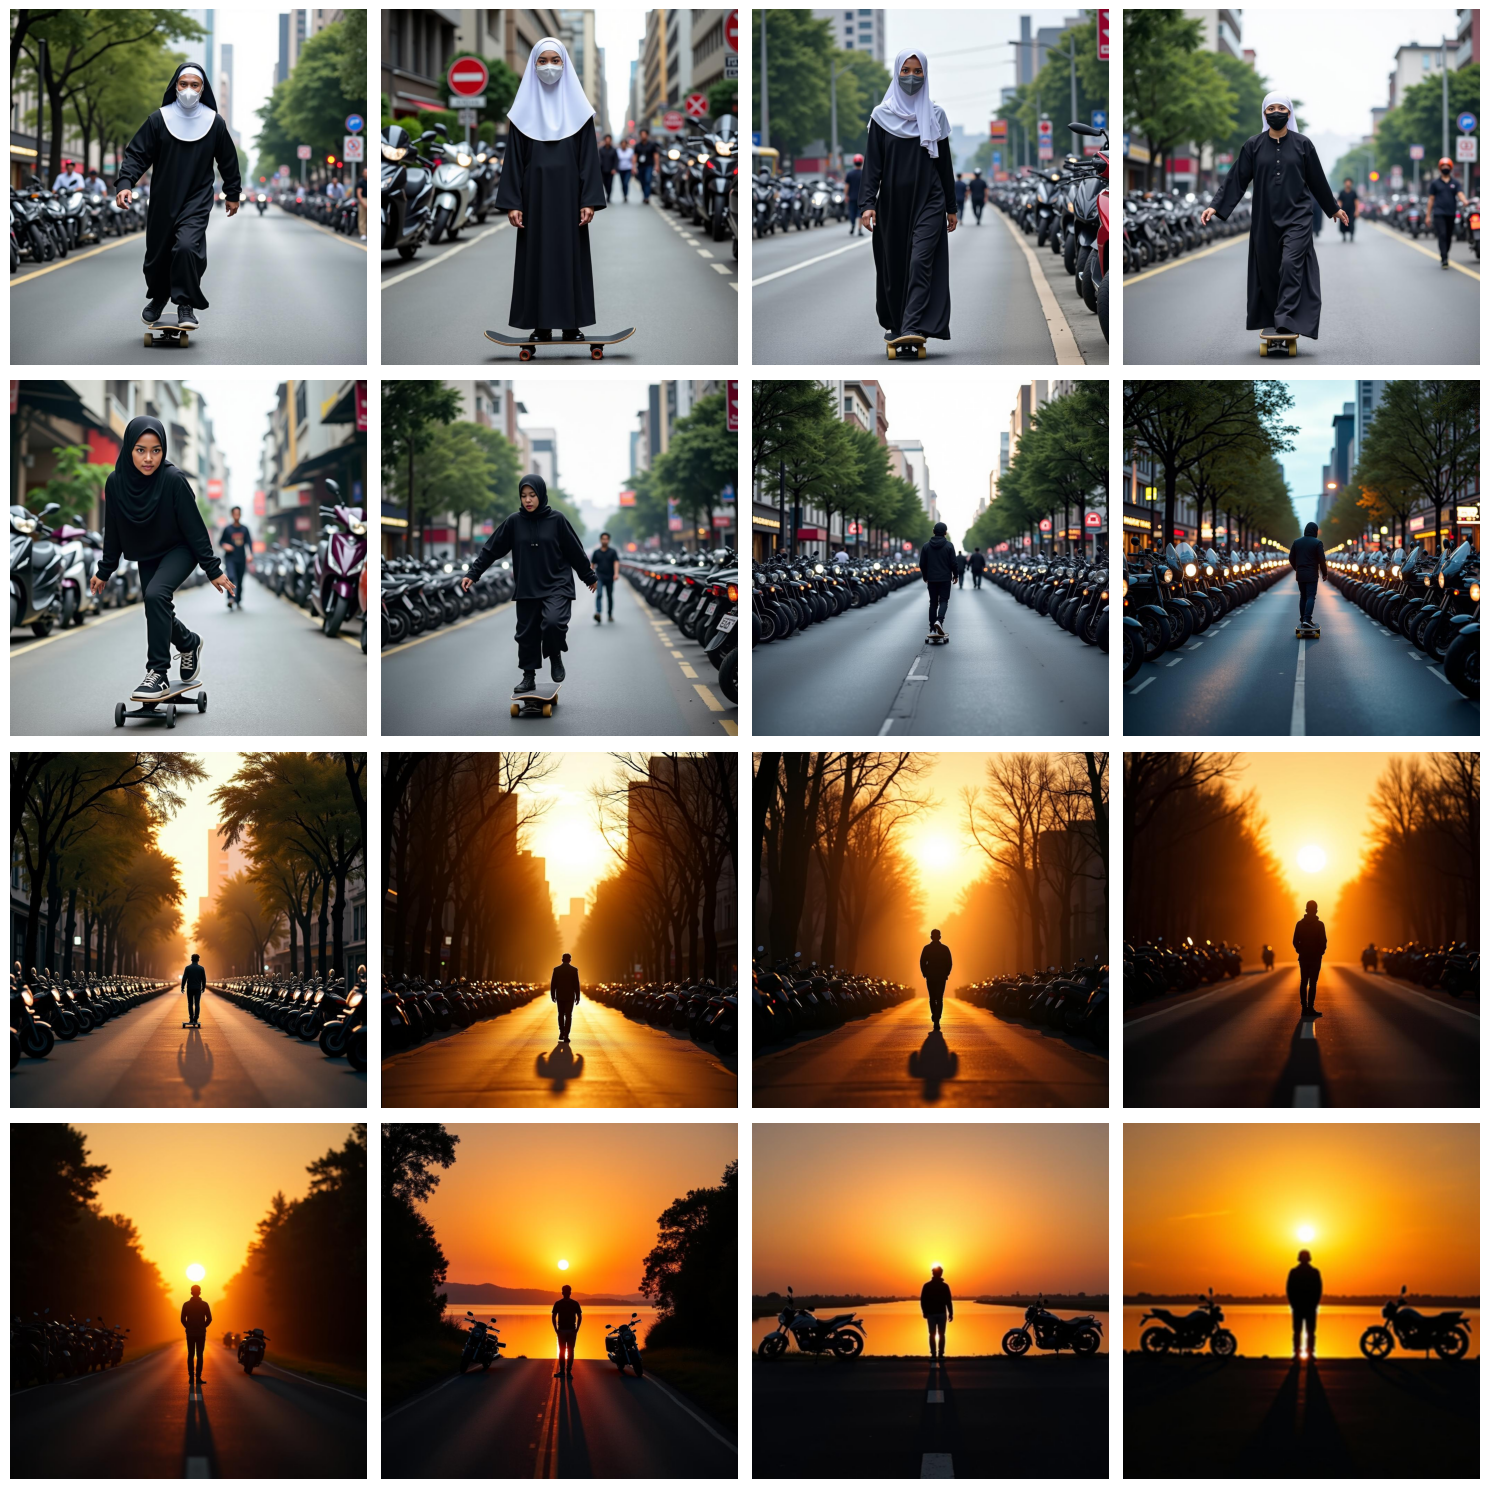

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

try:
    # Ruta de las imágenes (asegúrate de cambiarla por la tuya)
    folder_path = f'{directorio}/imagenes'
except NameError:
    directorio = f"{ruta_img}029_objetos/prompt_150_words"
    folder_path = f'{directorio}/imagenes'

# Obtener los nombres de las imágenes .jpg
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')][:16]

# Ordenar las imágenes numéricamente por el número en el nombre del archivo
image_files.sort(key=lambda x: int(x.split('generated_image')[1].split('.jpg')[0]))

# Crear una figura con un conjunto de subgráficas de 5x5
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# Recorrer cada imagen y colocarla en su subgráfico correspondiente
for i, ax in enumerate(axes.flat):
    if i < len(image_files):
        img = mpimg.imread(os.path.join(folder_path, image_files[i]))
        ax.imshow(img)
        ax.axis('off')  # Ocultar los ejes
    else:
        ax.axis('off')  # Si no hay más imágenes, ocultar el eje

plt.tight_layout()
# Guardar la figura como "resumen.jpg"
plt.savefig(f'{directorio}/resumen_largas_1.jpg', dpi=300)
plt.show()